# P1 - Identificando personas desde una imagen de su cara

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [1]:
# Librarías
from sklearn.datasets import fetch_lfw_people
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import preprocessing
from keras import backend as K
from livelossplot import PlotLossesKeras

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# DataSet : “Labeled Faces in the Wild”
min_faces_per_person = 60 # número mínimo de fotos por personaje para filtrar la base
resize=0.5 # Número de define la calidad de las imágenes

# con 10 mín  fotos se generan 158 categorías
# con 40 mín  fotos se generan 19 categorías
# con 50 mín  fotos se generan 12 categorías

In [3]:
# Some definitions

data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Resumen Imágenes a procesar")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

Resumen Imágenes a procesar
Samples: 1348
Classes: 8
Dimentions: (62, 47)


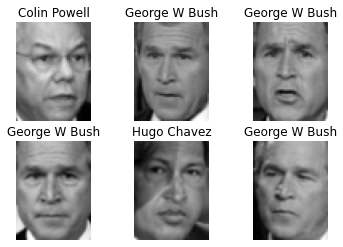

In [4]:
for i in range(6):
  img=X[i,:]
  img=img.reshape(W,H)
  plt.subplot(2,3,i+1)
  plt.title(target_names[y[i]])
  plt.imshow(img,cmap='gray')
  plt.axis('off')
plt.show()

In [5]:
# split into a training and testing set
X_train_image, X_test_image, y_train_labels, y_test_labels = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [6]:
#shape train
print(X_train_image.shape)
n_train=X_train_image.shape[0]

(1078, 2914)


In [7]:
#shape test
print(X_test_image.shape)
n_test=X_test_image.shape[0]

(270, 2914)


In [8]:
# Transformación 
X_train_image = X_train_image.reshape((n_train, W * H))
X_train_image = X_train_image.astype('float32') / 255
X_test_image = X_test_image.reshape((n_test, W * H))
X_test_image = X_test_image.astype('float32') / 255

In [9]:
# Categorización 
y_train_labels = to_categorical(y_train_labels)
y_test_labels = to_categorical(y_test_labels)

In [10]:
# Validación dimensiones variable respuesta en dataset de entrenamiento y pruebas
print(y_train_labels.shape)
print(y_test_labels.shape)

(1078, 8)
(270, 8)


### MODELO 1 - NN

In [11]:
# model compilation
K.clear_session()
model_1 = models.Sequential()
model_1.add(layers.Dense(570, activation='relu', input_shape=(W * H,)))
model_1.add(layers.Dense(95, activation='sigmoid'))
model_1.add(layers.Dense(classes, activation='softmax'))
model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 570)               1661550   
_________________________________________________________________
dense_1 (Dense)              (None, 95)                54245     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 768       
Total params: 1,716,563
Trainable params: 1,716,563
Non-trainable params: 0
_________________________________________________________________


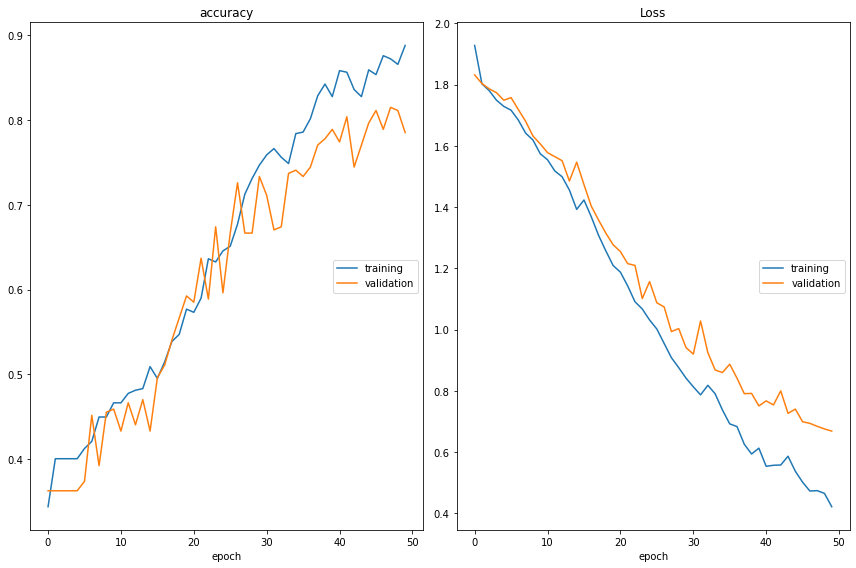

accuracy
	training         	 (min:    0.344, max:    0.888, cur:    0.888)
	validation       	 (min:    0.363, max:    0.815, cur:    0.785)
Loss
	training         	 (min:    0.421, max:    1.928, cur:    0.421)
	validation       	 (min:    0.668, max:    1.832, cur:    0.668)


In [12]:
# fit model
size = int(m/classes) # Tamaño de la ventana
epoc = 50 # Número de épocas

#model_1.fit(X_train_image, y_train_labels, epochs=epoc, batch_size=size)
model_1.fit(X_train_image, y_train_labels, validation_data=(X_test_image, y_test_labels), \
            epochs=epoc, batch_size=size, verbose=1, callbacks=[PlotLossesKeras()])

In [13]:
# model's performance on test set
test_loss, test_acc = model_1.evaluate(X_test_image, y_test_labels)

9/9 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.7852


### MODELO 2 - NN CON TUNNING 

In [14]:
K.clear_session()
def build_keras_base(hidden_layers = [512, 19],  
                     optimizer='adam'):
    model_opt = models.Sequential()
    model_opt.add(layers.Dense(570, activation='relu', input_shape=(W * H,)))
    model_opt.add(layers.Dense(95, activation='sigmoid'))
    model_opt.add(layers.Dense(classes, activation='softmax'))
    model_opt.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model_opt

In [15]:
model_keras = KerasClassifier(
    build_fn = build_keras_base, verbose=0
   
)

In [16]:
hidden_layers_opt=[[580,100], [256, 64],[512,128]] 
batch_size_opt= [size, 50,150] 
epochs_opt= [50,60]
optimizer= ['sgd', 'rmsprop',"adam"]

parameters_opt = {'hidden_layers':hidden_layers_opt,
                  'optimizer': optimizer,
                  'batch_size': batch_size_opt, 
                  'epochs': epochs_opt , 
                  
                 }

In [17]:
grid_search =  RandomizedSearchCV(model_keras,
                                  param_distributions = parameters_opt, 
                                  scoring = 'accuracy', 
                                  n_iter = 3, 
                                  cv = 10)

In [18]:
rounded_labels=np.argmax(y_train_labels, axis=1)
rounded_labels[1]

1

In [19]:
grid_result = grid_search.fit(X_train_image, rounded_labels, verbose=0)

In [20]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print(best_accuracy)

{'optimizer': 'adam', 'hidden_layers': [256, 64], 'epochs': 60, 'batch_size': 168}
0.769055036344756


In [21]:
# model compilation
K.clear_session()
model_opt1 = models.Sequential()
model_opt1.add(layers.Dense(256, activation='relu', input_shape=(W * H,)))
model_opt1.add(layers.Dense(64, activation='sigmoid'))
model_opt1.add(layers.Dense(classes, activation='softmax'))
model_opt1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_opt1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               746240    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 763,208
Trainable params: 763,208
Non-trainable params: 0
_________________________________________________________________


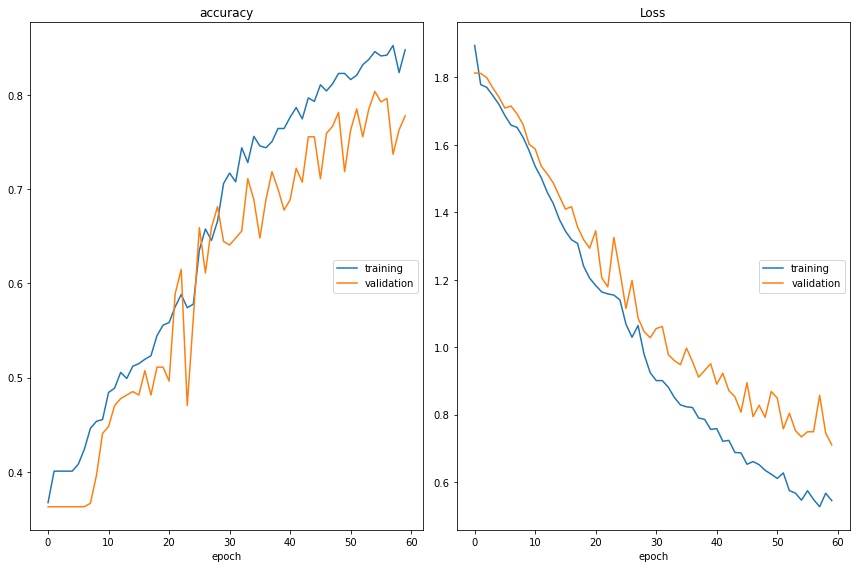

accuracy
	training         	 (min:    0.367, max:    0.853, cur:    0.848)
	validation       	 (min:    0.363, max:    0.804, cur:    0.778)
Loss
	training         	 (min:    0.527, max:    1.895, cur:    0.545)
	validation       	 (min:    0.710, max:    1.813, cur:    0.710)


In [22]:
# fit model
size = 168 # Tamaño de la ventana
epoc = 60 # Número de épocas

model_opt1.fit(X_train_image, y_train_labels, validation_data=(X_test_image, y_test_labels), \
            epochs=epoc, batch_size=size, verbose=1, callbacks=[PlotLossesKeras()])

In [23]:
# model's performance on test set
test_loss, test_acc = model_opt1.evaluate(X_test_image, y_test_labels, verbose=1)

9/9 [==============================] - 0s 1ms/step - loss: 0.7100 - accuracy: 0.7778


### MODELO 3 - PCA

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_image)
X_sc_train = scaler.transform(X_train_image)
X_sc_test = scaler.transform(X_test_image)

Text(0, 0.5, 'Cumulative explained variance')

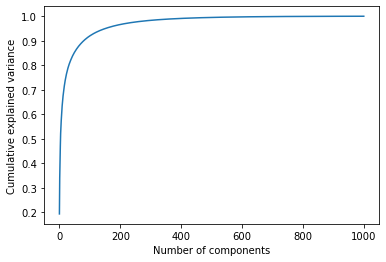

In [25]:
pca = PCA(n_components=1000)
pca.fit(X_train_image)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [26]:
NCOMPONENTS = 200

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

print(X_sc_train.shape)
print(X_pca_train.shape)

(1078, 2914)
(1078, 200)


In [27]:
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scaler.inverse_transform(inv_pca)

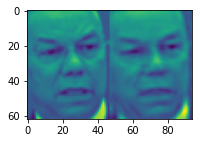

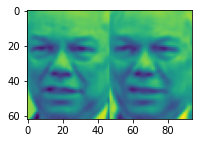

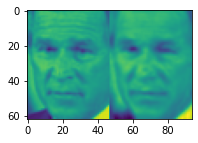

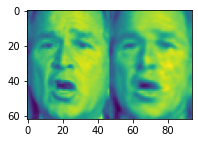

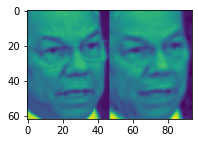

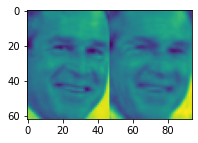

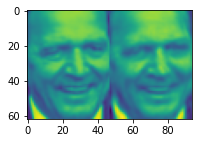

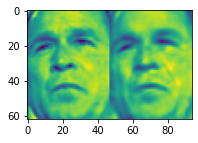

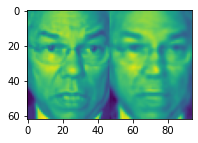

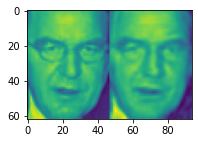

In [28]:
def side_by_side(indexes):
    org = X_train_image[indexes].reshape(W,H)
    rec = inv_sc[indexes].reshape(W,H)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
for index in range(0,10):
    side_by_side(index)

In [29]:
# model compilation
K.clear_session()
model_pca = models.Sequential()
model_pca.add(layers.Dense(580, activation='relu', input_dim=NCOMPONENTS))
model_pca.add(layers.Dense(100, activation='sigmoid'))
model_pca.add(layers.Dense(classes, activation='softmax'))
model_pca.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_pca.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 580)               116580    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               58100     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 175,488
Trainable params: 175,488
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_pca.fit(X_pca_train, y_train_labels, epochs=100, batch_size=256, validation_split=0.15, verbose=2)

Epoch 1/100
4/4 - 1s - loss: 1.9421 - accuracy: 0.2828 - val_loss: 1.6617 - val_accuracy: 0.4074
Epoch 2/100
4/4 - 0s - loss: 1.5203 - accuracy: 0.4487 - val_loss: 1.4650 - val_accuracy: 0.4938
Epoch 3/100
4/4 - 0s - loss: 1.2372 - accuracy: 0.5797 - val_loss: 1.3126 - val_accuracy: 0.5926
Epoch 4/100
4/4 - 0s - loss: 1.0186 - accuracy: 0.7085 - val_loss: 1.1385 - val_accuracy: 0.6235
Epoch 5/100
4/4 - 0s - loss: 0.8431 - accuracy: 0.7817 - val_loss: 1.0328 - val_accuracy: 0.6667
Epoch 6/100
4/4 - 0s - loss: 0.6999 - accuracy: 0.8526 - val_loss: 0.9290 - val_accuracy: 0.7037
Epoch 7/100
4/4 - 0s - loss: 0.5681 - accuracy: 0.9072 - val_loss: 0.8629 - val_accuracy: 0.7284
Epoch 8/100
4/4 - 0s - loss: 0.4720 - accuracy: 0.9367 - val_loss: 0.8051 - val_accuracy: 0.7407
Epoch 9/100
4/4 - 0s - loss: 0.3876 - accuracy: 0.9531 - val_loss: 0.7553 - val_accuracy: 0.7284
Epoch 10/100
4/4 - 0s - loss: 0.3188 - accuracy: 0.9662 - val_loss: 0.7026 - val_accuracy: 0.7531
Epoch 11/100
4/4 - 0s - loss:

Epoch 85/100
4/4 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.5110 - val_accuracy: 0.8395
Epoch 86/100
4/4 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.5113 - val_accuracy: 0.8395
Epoch 87/100
4/4 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.5117 - val_accuracy: 0.8395
Epoch 88/100
4/4 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.5121 - val_accuracy: 0.8395
Epoch 89/100
4/4 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.5127 - val_accuracy: 0.8395
Epoch 90/100
4/4 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.5132 - val_accuracy: 0.8395
Epoch 91/100
4/4 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5136 - val_accuracy: 0.8395
Epoch 92/100
4/4 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.5142 - val_accuracy: 0.8395
Epoch 93/100
4/4 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.5145 - val_accuracy: 0.8395
Epoch 94/100
4/4 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.5147 - val_accuracy: 0.8457
Epoch 95/100
4/4 - 0

In [31]:
# model's performance on test set
test_loss, test_acc = model_pca.evaluate(X_pca_test, y_test_labels, verbose=1)

9/9 [==============================] - 0s 997us/step - loss: 0.4617 - accuracy: 0.8481


### BIBLIOGRAFÍA

https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression

https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python

https://github.com/harshitrai17152/Labeled-Faces-in-the-Wild.git
    